

<h1><center><font size=10> Introduction to LLMs and GenAI</center></font></h1>
<h1><center>Mini Project 2: Word2vec and GloVe</center></h1>

## Problem Statement

### Business Context

In today’s fast-paced e-commerce landscape, customer reviews significantly influence product perception and buying decisions. Businesses must actively monitor customer sentiment to extract insights and maintain a competitive edge. Ignoring negative feedback can lead to serious issues, such as:

Customer Churn: Unresolved complaints drive loyal customers away, reducing retention and future revenue.

Reputation Damage: Persistent negative sentiment can erode brand trust and deter new buyers.

Financial Loss: Declining sales and shifting customer preference toward competitors directly impact profitability.

Actively tracking and addressing customer sentiment is essential for sustained growth and brand strength.

### Problem Definition

A growing e-commerce platform specializing in electronic gadgets collects customer feedback from product reviews, surveys, and social media. With a 200% increase in their customer base over three years and a recent 25% spike in feedback volume, their manual review process is no longer sustainable.

To address this, the company aims to implement an AI-driven solution to automatically classify customer sentiments (positive, negative, or neutral).

As a Data Scientist, your task is to analyze the provided customer reviews—along with their labeled sentiments—and build a predictive model for sentiment classification.

=================================================================================================================

### Data Dictionary

- **Product ID**: An exclusive identification number for each product

- **Product Review**: Insights and opinions shared by customers about the product

- **Sentiment**: Sentiment associated with the product review, indicating whether the review expresses a positive, negative, or neutral sentiment

## Importing the necessary libraries

In [2]:
!pip install gensim

In [3]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

import gensim

# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# to create Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# to import Word2Vec
from gensim.models import Word2Vec

# to split data into train and test sets
from sklearn.model_selection import train_test_split

# to build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

# to compute metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# To tune different models
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhinavroyce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abhinavroyce/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the dataset

In [5]:
# loading data into a pandas dataframe
reviews = pd.read_csv("Product_Reviews.csv")

In [6]:
# creating a copy of the data
data = reviews.copy()

## Data Overview

### Checking the first five rows of the data

In [7]:
data.head(5)

,Product ID,Product Review,Sentiment
0,AVpe7AsMilAPnD_xQ78G,"I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.Fortunately, I had friends who owned each, so I ended up buying the paperwhite on this basis: both models now have 300 ppi, so the 80 dollar jump turns out pricey the voyage's page press isn't always sensitive, and if you are fine with a specific setting, you don't need auto light adjustment).It's been a week and I am loving my paperwhite, no regrets! The touch screen is receptive and easy to use, and I keep the light at a specific setting regardless of the time of day. (In any case, it's not hard to change the setting either, as you'll only be changing the light level at a certain time of day, not every now and then while reading).Also glad that I went for the international shipping option with Amazon. Extra expense, but delivery was on time, with tracking, and I didnt need to worry about customs, which I may have if I used a third party shipping service.",POSITIVE
1,AVpe7AsMilAPnD_xQ78G,"Allow me to preface this with a little history. I am (was) a casual reader who owned a Nook Simple Touch from 2011. I've read the Harry Potter series, Girl with the Dragon Tattoo series, 1984, Brave New World, and a few other key titles. Fair to say my Nook did not get as much use as many others may have gotten from theirs.Fast forward to today. I have had a full week with my new Kindle Paperwhite and I have to admit, I'm in love. Not just with the Kindle, but with reading all over again! Now let me relate this review, love, and reading all back to the Kindle. The investment of 139.00 is in the experience you will receive when you buy a Kindle. You are not simply paying for a screen there is an entire experience included in buying from Amazon.I have been reading The Hunger Games trilogy and shall be moving onto the Divergent series soon after. Here is the thing with the Nook that hindered me for the past 4 years: I was never inspired to pick it up, get it into my hands, and just dive in. There was never that feeling of oh man, reading on this thing is so awesome. However, with my Paperwhite, I now have that feeling! That desire is back and I simply adore my Kindle. If you are considering purchasing one, stop thinking about it simply go for it. After a full week, 3 downloaded books, and a ton of reading, I still have half of my battery left as well.Make yourself happy. Inspire the reader inside of you.",POSITIVE
2,AVpe7AsMilAPnD_xQ78G,I am enjoying it so far. Great for reading. Had the original Fire since 2012. The Fire used to make my eyes hurt if I read too long. Haven't experienced that with the Paperwhite yet.,POSITIVE
3,AVpe7AsMilAPnD_xQ78G,"I bought one of the first Paperwhites and have been very pleased with it its been a constant companion and I suppose Ive read, on average, a book every three days for the past however many years on it. I wouldnt give it up youd have to pry it from my cold dead fingers.For sundry logistical reasons, Ive also made good use of Amazons Kindle app on my iPhone. No Paperwhite screen, naturally, and all the cool usability that delivers, but it works well and has its own attractions as a companion to the Kindle.Of course, there are aspects of the Paperwhite which I would like to critique. Ah you knew that was coming somewhere, didnt you.As a member of BookBub, I get a daily list of alerts and book deals in my chosen genres. I take on many of them, however, Ive found that, even with the best will in the world, I cant keep up. Some days it seems that for every book I read, Ive bought two. Theres just so much good stuff out there! The accumulative effect of this is that the number of books actually on my Paperwhite has been creeping ever upward for some time. Its now at about 400.With this in mind, Ive noticed that while page-turning has remained exactly the 

### Checking the shape of the dataset

In [8]:
data.shape

(1007, 3)

* The dataset has 1007 rows and 3 columns.

### Checking for Missing Values

In [9]:
data.isnull().sum()

Product ID        0
Product Review    0
Sentiment         0
dtype: int64

* There are no missing values in the data

### Checking for duplicate values

In [10]:
# checking for duplicate values
data.duplicated().sum()

np.int64(2)

* There are 2 duplicate values in the dataset.
* We'll drop them.

In [11]:
# dropping duplicate values
data = data.drop_duplicates()

data.duplicated().sum()

np.int64(0)

## Exploratory Data Analysis (EDA)


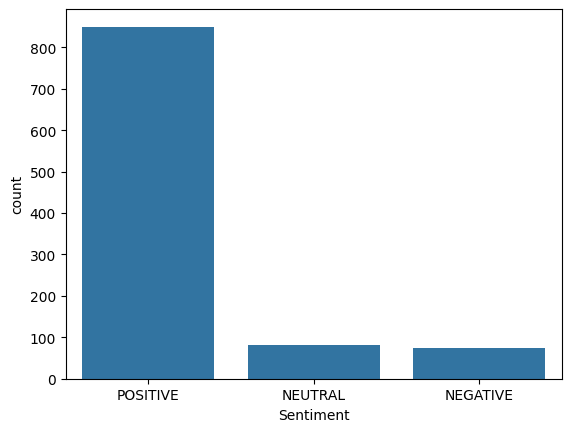

In [12]:
sns.countplot(data=data, x="Sentiment");

In [13]:
data['Sentiment'].value_counts(normalize=True)

Sentiment
POSITIVE    0.845771
NEUTRAL     0.080597
NEGATIVE    0.073632
Name: proportion, dtype: float64

- Majority of the reviews are positive (\~85%), followed by neutral reviews (8%), and then the positive reviews (\~7%)

=================================================================================================================

## Text Preprocessing

### Removing special characters from the text

In [14]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))

    return new_text

In [15]:
# Applying the function to remove special characters
data['cleaned_text'] = data['Product Review'].apply(remove_special_characters)

In [16]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['Product Review','cleaned_text']]

,Product Review,cleaned_text
0,"I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.Fortunately, I had friends who owned each, so I ended up buying the paperwhite on this basis: both models now have 300 ppi, so the 80 dollar jump turns out pricey the voyage's page press isn't always sensitive, and if you are fine with a specific setting, you don't need auto light adjustment).It's been a week and I am loving my paperwhite, no regrets! The touch screen is receptive and easy to use, and I keep the light at a specific setting regardless of the time of day. (In any case, it's not hard to change the setting either, as you'll only be changing the light level at a certain time of day, not every now and then while reading).Also glad that I went for the international shipping option with Amazon. Extra expense, but delivery was on time, with tracking, and I didnt need to worry about customs, which I may have if I used a third party shipping service.",I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing the paperwhite is great but if you have spending money go for the voyage Fortunately I had friends who owned each so I ended up buying the paperwhite on this basis both models now have 300 ppi so the 80 dollar jump turns out pricey the voyage s page press isn t always sensitive and if you are fine with a specific setting you don t need auto light adjustment It s been a week and I am loving my paperwhite no regrets The touch screen is receptive and easy to use and I keep the light at a specific setting regardless of the time of day In any case it s not hard to change the setting either as you ll only be changing the light level at a certain time of day not every now and then while reading Also glad that I went for the international shipping option with Amazon Extra expense but delivery was on time with tracking and I didnt need to worry about customs which I may have if I used a third party shipping service
1,"Allow me to preface this with a little history. I am (was) a casual reader who owned a Nook Simple Touch from 2011. I've read the Harry Potter series, Girl with the Dragon Tattoo series, 1984, Brave New World, and a few other key titles. Fair to say my Nook did not get as much use as many others may have gotten from theirs.Fast forward to today. I have had a full week with my new Kindle Paperwhite and I have to admit, I'm in love. Not just with the Kindle, but with reading all over again! Now let me relate this review, love, and reading all back to the Kindle. The investment of 139.00 is in the experience you will receive when you buy a Kindle. You are not simply paying for a screen there is an entire experience included in buying from Amazon.I have been reading The Hunger Games trilogy and shall be moving onto the Divergent series soon after. Here is the thing with the Nook that hindered me for the past 4 years: I was never inspired to pick it up, get it into my hands, and just dive in. There was never that feeling of oh man, reading on this thing is so awesome. However, with my Paperwhite, I now have that feeling! That desire is back and I simply adore my Kindle. If you are considering purchasing one, stop thinking about it simply go for it. After a full week, 3 downloaded books, and a ton of reading, I still have half of my battery left as well.Make yourself happy. Inspire the reader inside of you.",Allow me to preface this with a little history I am was a casual reader who owned a Nook Simple Touch from 2011 I ve read the Harry Potter series Girl with the Dragon Tattoo series 1984 Brave New World and a few other key titles Fair to say my Nook did not get as much use as many others may have gotten from theirs Fast forward to today I have had a full week with my new Kindle Paperwhite and I have to admit I m in love Not just w

- We can observe that the function removed the special characters and retained the alphabets and numbers.

### Lowercasing

In [17]:
# changing the case of the text data to lower case
data['cleaned_text'] = data['cleaned_text'].str.lower()

In [18]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['Product Review','cleaned_text']]

,Product Review,cleaned_text
0,"I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.Fortunately, I had friends who owned each, so I ended up buying the paperwhite on this basis: both models now have 300 ppi, so the 80 dollar jump turns out pricey the voyage's page press isn't always sensitive, and if you are fine with a specific setting, you don't need auto light adjustment).It's been a week and I am loving my paperwhite, no regrets! The touch screen is receptive and easy to use, and I keep the light at a specific setting regardless of the time of day. (In any case, it's not hard to change the setting either, as you'll only be changing the light level at a certain time of day, not every now and then while reading).Also glad that I went for the international shipping option with Amazon. Extra expense, but delivery was on time, with tracking, and I didnt need to worry about customs, which I may have if I used a third party shipping service.",i initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing the paperwhite is great but if you have spending money go for the voyage fortunately i had friends who owned each so i ended up buying the paperwhite on this basis both models now have 300 ppi so the 80 dollar jump turns out pricey the voyage s page press isn t always sensitive and if you are fine with a specific setting you don t need auto light adjustment it s been a week and i am loving my paperwhite no regrets the touch screen is receptive and easy to use and i keep the light at a specific setting regardless of the time of day in any case it s not hard to change the setting either as you ll only be changing the light level at a certain time of day not every now and then while reading also glad that i went for the international shipping option with amazon extra expense but delivery was on time with tracking and i didnt need to worry about customs which i may have if i used a third party shipping service
1,"Allow me to preface this with a little history. I am (was) a casual reader who owned a Nook Simple Touch from 2011. I've read the Harry Potter series, Girl with the Dragon Tattoo series, 1984, Brave New World, and a few other key titles. Fair to say my Nook did not get as much use as many others may have gotten from theirs.Fast forward to today. I have had a full week with my new Kindle Paperwhite and I have to admit, I'm in love. Not just with the Kindle, but with reading all over again! Now let me relate this review, love, and reading all back to the Kindle. The investment of 139.00 is in the experience you will receive when you buy a Kindle. You are not simply paying for a screen there is an entire experience included in buying from Amazon.I have been reading The Hunger Games trilogy and shall be moving onto the Divergent series soon after. Here is the thing with the Nook that hindered me for the past 4 years: I was never inspired to pick it up, get it into my hands, and just dive in. There was never that feeling of oh man, reading on this thing is so awesome. However, with my Paperwhite, I now have that feeling! That desire is back and I simply adore my Kindle. If you are considering purchasing one, stop thinking about it simply go for it. After a full week, 3 downloaded books, and a ton of reading, I still have half of my battery left as well.Make yourself happy. Inspire the reader inside of you.",allow me to preface this with a little history i am was a casual reader who owned a nook simple touch from 2011 i ve read the harry potter series girl with the dragon tattoo series 1984 brave new world and a few other key titles fair to say my nook did not get as much use as many others may have gotten from theirs fast forward to today i have had a full week with my new kindle paperwhite and i have to admit i m in love not just w

- We can observe that all the text has now successfully been converted to lower case.

### Removing extra whitespace

In [19]:
# removing extra whitespaces from the text
data['cleaned_text'] = data['cleaned_text'].str.strip()

In [20]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['Product Review','cleaned_text']]

,Product Review,cleaned_text
0,"I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.Fortunately, I had friends who owned each, so I ended up buying the paperwhite on this basis: both models now have 300 ppi, so the 80 dollar jump turns out pricey the voyage's page press isn't always sensitive, and if you are fine with a specific setting, you don't need auto light adjustment).It's been a week and I am loving my paperwhite, no regrets! The touch screen is receptive and easy to use, and I keep the light at a specific setting regardless of the time of day. (In any case, it's not hard to change the setting either, as you'll only be changing the light level at a certain time of day, not every now and then while reading).Also glad that I went for the international shipping option with Amazon. Extra expense, but delivery was on time, with tracking, and I didnt need to worry about customs, which I may have if I used a third party shipping service.",i initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing the paperwhite is great but if you have spending money go for the voyage fortunately i had friends who owned each so i ended up buying the paperwhite on this basis both models now have 300 ppi so the 80 dollar jump turns out pricey the voyage s page press isn t always sensitive and if you are fine with a specific setting you don t need auto light adjustment it s been a week and i am loving my paperwhite no regrets the touch screen is receptive and easy to use and i keep the light at a specific setting regardless of the time of day in any case it s not hard to change the setting either as you ll only be changing the light level at a certain time of day not every now and then while reading also glad that i went for the international shipping option with amazon extra expense but delivery was on time with tracking and i didnt need to worry about customs which i may have if i used a third party shipping service
1,"Allow me to preface this with a little history. I am (was) a casual reader who owned a Nook Simple Touch from 2011. I've read the Harry Potter series, Girl with the Dragon Tattoo series, 1984, Brave New World, and a few other key titles. Fair to say my Nook did not get as much use as many others may have gotten from theirs.Fast forward to today. I have had a full week with my new Kindle Paperwhite and I have to admit, I'm in love. Not just with the Kindle, but with reading all over again! Now let me relate this review, love, and reading all back to the Kindle. The investment of 139.00 is in the experience you will receive when you buy a Kindle. You are not simply paying for a screen there is an entire experience included in buying from Amazon.I have been reading The Hunger Games trilogy and shall be moving onto the Divergent series soon after. Here is the thing with the Nook that hindered me for the past 4 years: I was never inspired to pick it up, get it into my hands, and just dive in. There was never that feeling of oh man, reading on this thing is so awesome. However, with my Paperwhite, I now have that feeling! That desire is back and I simply adore my Kindle. If you are considering purchasing one, stop thinking about it simply go for it. After a full week, 3 downloaded books, and a ton of reading, I still have half of my battery left as well.Make yourself happy. Inspire the reader inside of you.",allow me to preface this with a little history i am was a casual reader who owned a nook simple touch from 2011 i ve read the harry potter series girl with the dragon tattoo series 1984 brave new world and a few other key titles fair to say my nook did not get as much use as many others may have gotten from theirs fast forward to today i have had a full week with my new kindle paperwhite and i have to admit i m in love not just w

### Removing stopwords

* The idea with stop word removal is to **exclude words that appear frequently throughout** all the documents in the corpus.
* Pronouns and articles are typically categorized as stop words.
* The `NLTK` library has an in-built list of stop words and it can utilize that list to remove the stop words from a dataset.

In [21]:
# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])

    return new_text

In [22]:
# Applying the function to remove stop words using the NLTK library
data['cleaned_text_without_stopwords'] = data['cleaned_text'].apply(remove_stopwords)

In [23]:
# checking a couple of instances of cleaned data
data.loc[0:3,['cleaned_text','cleaned_text_without_stopwords']]

,cleaned_text,cleaned_text_without_stopwords
0,i initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing the paperwhite is great but if you have spending money go for the voyage fortunately i had friends who owned each so i ended up buying the paperwhite on this basis both models now have 300 ppi so the 80 dollar jump turns out pricey the voyage s page press isn t always sensitive and if you are fine with a specific setting you don t need auto light adjustment it s been a week and i am loving my paperwhite no regrets the touch screen is receptive and easy to use and i keep the light at a specific setting regardless of the time of day in any case it s not hard to change the setting either as you ll only be changing the light level at a certain time of day not every now and then while reading also glad that i went for the international shipping option with amazon extra expense but delivery was on time with tracking and i didnt need to worry about customs which i may have if i used a third party shipping service,initially trouble deciding paperwhite voyage reviews less said thing paperwhite great spending money go voyage fortunately friends owned ended buying paperwhite basis models 300 ppi 80 dollar jump turns pricey voyage page press always sensitive fine specific setting need auto light adjustment week loving paperwhite regrets touch screen receptive easy use keep light specific setting regardless time day case hard change setting either changing light level certain time day every reading also glad went international shipping option amazon extra expense delivery time tracking didnt need worry customs may used third party shipping service
1,allow me to preface this with a little history i am was a casual reader who owned a nook simple touch from 2011 i ve read the harry potter series girl with the dragon tattoo series 1984 brave new world and a few other key titles fair to say my nook did not get as much use as many others may have gotten from theirs fast forward to today i have had a full week with my new kindle paperwhite and i have to admit i m in love not just with the kindle but with reading all over again now let me relate this review love and reading all back to the kindle the investment of 139 00 is in the experience you will receive when you buy a kindle you are not simply paying for a screen there is an entire experience included in buying from amazon i have been reading the hunger games trilogy and shall be moving onto the divergent series soon after here is the thing with the nook that hindered me for the past 4 years i was never inspired to pick it up get it into my hands and just dive in there was never that feeling of oh man reading on this thing is so awesome however with my paperwhite i now have that feeling that desire is back and i simply adore my kindle if you are considering purchasing one stop thinking about it simply go for it after a full week 3 downloaded books and a ton of reading i still have half of my battery left as well make yourself happy inspire the reader inside of you,allow preface little history casual reader owned nook simple touch 2011 read harry potter series girl dragon tattoo series 1984 brave new world key titles fair say nook get much use many others may gotten fast forward today full week new kindle paperwhite admit love kindle reading let relate review love reading back kindle investment 139 00 experience receive buy kindle simply paying screen entire experience included buying amazon reading hunger games trilogy shall moving onto divergent series soon thing nook hindered past 4 years never inspired pick get hands dive never feeling oh man reading thing awesome however paperwhite feeling desire back simply adore kindle considering purchasing one stop thinking simply go full week 3 downloaded books ton reading still half battery left well make happy inspire reader inside
2,i am enjoying it so far great for reading had the o

* We observe that all the stopwords have been removed.

### Stemming/Lemmatization
We will use lemmatization because we got better results using that on our dataset.

In [24]:
# Function to apply lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet #Downloads the WordNet lexical database.WordNet is adictionary-like database where Words are grouped into sets of synonyms
import nltk

# Make sure to download WordNet resources if not already done
nltk.download('wordnet')
nltk.download('omw-1.4') # Open Multilingual WordNet package -This adds language translations, richer word forms, and improved morphological data to WordNet.

lemmatizer = WordNetLemmatizer()

# defining a function to perform stemming
def apply_lemmatizer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([lemmatizer.lemmatize(word) for word in words])

    return new_text

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abhinavroyce/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/abhinavroyce/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [25]:
# Applying the function to perform stemming
data['final_cleaned_text'] = data['cleaned_text_without_stopwords'].apply(apply_lemmatizer)

In [26]:
# checking a couple of instances of cleaned data
data.loc[0:2,['cleaned_text_without_stopwords','final_cleaned_text']]

,cleaned_text_without_stopwords,final_cleaned_text
0,initially trouble deciding paperwhite voyage reviews less said thing paperwhite great spending money go voyage fortunately friends owned ended buying paperwhite basis models 300 ppi 80 dollar jump turns pricey voyage page press always sensitive fine specific setting need auto light adjustment week loving paperwhite regrets touch screen receptive easy use keep light specific setting regardless time day case hard change setting either changing light level certain time day every reading also glad went international shipping option amazon extra expense delivery time tracking didnt need worry customs may used third party shipping service,initially trouble deciding paperwhite voyage review less said thing paperwhite great spending money go voyage fortunately friend owned ended buying paperwhite basis model 300 ppi 80 dollar jump turn pricey voyage page press always sensitive fine specific setting need auto light adjustment week loving paperwhite regret touch screen receptive easy use keep light specific setting regardless time day case hard change setting either changing light level certain time day every reading also glad went international shipping option amazon extra expense delivery time tracking didnt need worry custom may used third party shipping service
1,allow preface little history casual reader owned nook simple touch 2011 read harry potter series girl dragon tattoo series 1984 brave new world key titles fair say nook get much use many others may gotten fast forward today full week new kindle paperwhite admit love kindle reading let relate review love reading back kindle investment 139 00 experience receive buy kindle simply paying screen entire experience included buying amazon reading hunger games trilogy shall moving onto divergent series soon thing nook hindered past 4 years never inspired pick get hands dive never feeling oh man reading thing awesome however paperwhite feeling desire back simply adore kindle considering purchasing one stop thinking simply go full week 3 downloaded books ton reading still half battery left well make happy inspire reader inside,allow preface little history casual reader owned nook simple touch 2011 read harry potter series girl dragon tattoo series 1984 brave new world key title fair say nook get much use many others may gotten fast forward today full week new kindle paperwhite admit love kindle reading let relate review love reading back kindle investment 139 00 experience receive buy kindle simply paying screen entire experience included buying amazon reading hunger game trilogy shall moving onto divergent series soon thing nook hindered past 4 year never inspired pick get hand dive never feeling oh man reading thing awesome however paperwhite feeling desire back simply adore kindle considering purchasing one stop thinking simply go full week 3 downloaded book ton reading still half battery left well make happy inspire reader inside
2,enjoying far great reading original fire since 2012 fire used make eyes hurt read long experienced paperwhite yet,enjoying far great reading original fire since 2012 fire used make eye hurt read long experienced paperwhite yet


=================================================================================================================

## Text Vectorization

### 1. Count Vectorizer

- We'll use the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class of sklearn to vectorize the data using Bag of Words (BoW).

- We first create the document-term matrix, where each value in the matrix stores the count of a term in a document.

- We then consider only the top *n* terms by frequency
    - *n* is a hyperparameter that one can change and experiment with

In [27]:
# Initializing CountVectorizer with top 1000 words
bow_vec = CountVectorizer(max_features = 1000)

# Applying CountVectorizer on data
data_features_BOW = bow_vec.fit_transform(data['final_cleaned_text'])

# Convert the data features to array
data_features_BOW = data_features_BOW.toarray()


# Shape of the feature vector
print("Shape of the feature vector",data_features_BOW.shape)

# Getting the 1000 words considered by the BoW model
words = bow_vec.get_feature_names_out()

print("first 10 words",words[:10])
print("last 10 words",words[-10:])

# Creating a DataFrame from the data features
df_BOW = pd.DataFrame(data_features_BOW, columns=bow_vec.get_feature_names_out())
df_BOW.head()


Shape of the feature vector (1005, 1000)
first 10 words ['10' '100' '11' '139' '15' '16' '17' '20' '2013' '2014']
last 10 words ['worth' 'would' 'write' 'writing' 'wrong' 'year' 'yes' 'yet' 'youll'
 'youtube']


,10,100,11,139,15,16,17,20,2013,2014,...,worth,would,write,writing,wrong,year,yes,yet,youll,youtube
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


- From the above dataframe, we can observe that the word *yet* is present only once in the third document, and the word *would* is presented twice in the fourth document.

## 2. Word2Vec


Word2Vec is a popular technique to convert words into numerical vectors (i.e., embeddings) so that similar words end up having similar vector representations. It helps machines understand the semantic meaning of words based on their context in sentences.

* REAL BENEFIT

  * After training on a large corpus, Word2Vec embeddings capture interesting relationships:

    * vector("king") - vector("man") + vector("woman") ≈ vector("queen")


#### HOW IT WORKS:
Word2Vec has two main models:
* 1. CBOW (Continuous Bag of Words)- Predicts the target word from surrounding context words.
* 2. Skip-gram- Predicts surrounding context words from a target word.



#### Summary:
* Word2Vec turns words into vectors based on their context.

* It helps models understand semantic relationships.

* It works best when trained on large text corpora (like Wikipedia, Google News, etc.).


### 2.1 CBOW

* Example

"The cat sat on the mat"

We'll use a context window of 2 (i.e., two words before and after the target word).
* CBOW works opposite of Skip-gram:

Instead of predicting context from a word, it predicts the word from its context.

| Context (Input Words) | Target (Predicted Word) |
| --------------------- | ----------------------- |
| \["The", "sat"]       | "cat"                   |
| \["cat", "on"]        | "sat"                   |
| \["sat", "the"]       | "on"                    |
| \["on", "mat"]        | "the"                   |

* Note: When using a window size of 2, you can include 2 words on either side if available.

So, the CBOW model is trained to learn that the center word ("cat") is likely when "The" and "sat" are around it.

In [28]:
# Example CBOW
# Note-
  # sg=0 → model is trained to predict target word from context (CBOW)
  # sg=1 → model is trained to predict context words from target (Skip-gram)


from gensim.models import Word2Vec

# Define corpus
sentences = [
    ["the", "cat", "sat", "on", "the", "mat"],
    ["the", "dog", "sat", "on", "the", "rug"],
    ["cats", "and", "dogs", "are", "friends"],
    ["the", "puppy", "played", "with", "the", "ball"],
    ["the", "kitten", "played", "with", "the", "yarn"]
]



# CBOW model (sg=0 for CBOW, sg=1 for skip-gram)
cbow_model = Word2Vec(sentences, vector_size=10, window=2, min_count=1, sg=0)
"""
PARAMETERS:
1. vector_size=10
What it means: Number of dimensions in the word vector.
Example: "cat" → [0.12, -0.56, 0.91, ...] (10 numbers)
Tip: Bigger vectors can store more meaning but need more data & computation.

2. window=2
What it means: How many words before & after the target word are considered context.
Example: In "The cat sat on the mat",
if target = "sat", window=2 → context = "cat", "on", "the", "mat".
Tip:
Small window → local grammar relationships
Large window → broader semantic relationships

3. min_count=1
What it means: Minimum word frequency to be included in the vocabulary.
Example:
min_count=1 → keep all words (good for small datasets)
min_count=5 → ignore words that appear fewer than 5 times (good for large datasets).
Tip: Helps remove rare, noisy words in big corpora.

4. sg=0 or sg=1
What it means: Chooses the training algorithm.
sg=0 → CBOW (predict target word from context)
sg=1 → Skip-gram (predict context words from target)
Example:
CBOW: "cat", "on" → "sat"
Skip-gram: "sat" → "cat", "on"
Tip:
CBOW is faster & works well with frequent words.
Skip-gram is slower but works better with rare words.

5. workers
What it means: Number of CPU threads to use in training.
Word2Vec can process multiple parts of the training data in parallel to speed things up.
Example:
workers=1 → use only 1 CPU core (slower, but deterministic results)
workers=4 → use 4 CPU cores (faster)
Tip:
On your personal machine, you can set it to the number of cores you have.
On Colab / Jupyter with small datasets, it won’t matter much — but for huge corpora, it makes training much faster."""

# Vector for a word
print("Vector for 'cat':")
print(cbow_model.wv['cat'])

# Similar words to 'cat'
print("\nWords similar to 'cat'and the cosine of angles between those vectors:")
print(cbow_model.wv.most_similar('cat'))


Vector for 'cat':
[-0.037098   -0.08745642  0.05437467  0.06509756 -0.0078755  -0.06709856
 -0.07085925 -0.0249706   0.05143254 -0.03665238]

Words similar to 'cat'and the cosine of angles between those vectors:
[('are', 0.27365267276763916), ('the', 0.17413146793842316), ('friends', 0.10869812220335007), ('on', 0.09501686692237854), ('with', -0.03493938967585564), ('and', -0.069147489964962), ('puppy', -0.09755348414182663), ('dogs', -0.1414671540260315), ('played', -0.14935949444770813), ('sat', -0.15872740745544434)]


### 2.2 Skip-gram

* EXAMPLE:

Let's say we have this simple sentence as our training corpus:

"The cat sat on the mat"

Suppose we want to train a Skip-gram model with a context window of 2.
We'll break the sentence into word pairs where the target word predicts context words.

Skip-gram pairs (target → context):

target: "cat" → context: "The", "sat"

target: "sat" → context: "cat", "on"

target: "on" → context: "sat", "the"

target: "the" → context: "on", "mat"

* The model learns vector representations (say, 100-dimensional) for each word, so that:

  * Words that appear in similar contexts (like "cat" and "dog" if seen in a bigger dataset) will have similar vectors.

  * The distance (cosine similarity) between similar words will be small (close to 1).

In [33]:
# Example on skip gram
from gensim.models import Word2Vec

# Simple corpus
sentences = [
    ["the", "cat", "sat", "on", "the", "mat"],
    ["the", "dog", "sat", "on", "the", "rug"],
    ["cats", "and", "dogs", "are", "friends"],
    ["the", "puppy", "played", "with", "the", "ball"],
    ["the", "kitten", "played", "with", "the", "yarn"]
]


# Train Word2Vec model
model = Word2Vec(sentences, vector_size=10, window=2, min_count=1, sg=1)

# Get vector for 'cat'
print(model.wv['cat'])

# Find similar words
print(model.wv.most_similar('cat'))


[-0.037098   -0.08745642  0.05437467  0.06509756 -0.0078755  -0.06709856
 -0.07085925 -0.0249706   0.05143254 -0.03665238]
[('are', 0.2736479938030243), ('the', 0.1740778684616089), ('friends', 0.10869812220335007), ('on', 0.09503733366727829), ('with', -0.03499068319797516), ('and', -0.06913430988788605), ('puppy', -0.09739808738231659), ('dogs', -0.1414671540260315), ('played', -0.14935949444770813), ('sat', -0.15872740745544434)]


### CBOW vs Skip-gram Summary
| Feature    | CBOW                      | Skip-gram             |
| ---------- | ------------------------- | --------------------- |
| Input      | Surrounding context words | Target word           |
| Output     | Predict center word       | Predict context words |
| Faster on  | Large datasets            | Small datasets        |
| Better for | Frequent words            | Rare words            |


## Now Applying on our dataset

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np


# Step 1 — Tokenize the text
sentences = data['final_cleaned_text'].apply(lambda x: x.split())  # assuming text is already cleaned

# Step 2 — Train CBOW Model (sg=0)
cbow_model = Word2Vec(
    sentences,
    vector_size=100,  # length of each word vector
    window=3,         # context window size
    min_count=5,      # include all words
    sg=0,             # CBOW
    workers=4         # CPU cores to use
)

# Step 3 — Train Skip-gram Model (sg=1)
skipgram_model = Word2Vec(
    sentences,
    vector_size=100,
    window=3,
    min_count=5,
    sg=1,             # Skip-gram
    workers=4
)

# Step 4 — Function to get sentence vectors
def get_sentence_vector(model, tokens):
    word_vecs = [model.wv[word] for word in tokens if word in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(model.vector_size)  # handle empty sentences
    return np.mean(word_vecs, axis=0)

# Step 5 — Apply to dataset

# CBOW Vectors
data_cbow_vectors = np.array([get_sentence_vector(cbow_model, tokens) for tokens in sentences])
# Skip-gram Vectors
data_skipgram_vectors = np.array([get_sentence_vector(skipgram_model, tokens) for tokens in sentences])

# Step 6 — Convert to DataFrames (optional)
df_cbow = pd.DataFrame(data_cbow_vectors)
df_skipgram = pd.DataFrame(data_skipgram_vectors)




In [31]:
# Checking top 5 similar words to the word 'book'
similar = cbow_model.wv.similar_by_word('book', topn=5)
print(similar)

[('able', 0.9993737936019897), ('still', 0.9993154406547546), ('user', 0.9992977380752563), ('another', 0.9992737770080566), ('many', 0.9992709755897522)]


In [39]:
# Checking top 5 similar words to the word 'review'
similar = cbow_model.wv.similar_by_word('review', topn=5)
print(similar)


[('voyage', 0.9996652007102966), ('read', 0.9996519088745117), ('also', 0.9996459484100342), ('time', 0.999639630317688), ('since', 0.9996172189712524)]


In [40]:
similar = skipgram_model.wv.similar_by_word('review', topn=5)
print(similar)


[('impression', 0.9857258796691895), ('139', 0.9833592176437378), ('released', 0.9833575487136841), ('keyboard', 0.9832817316055298), ('2012', 0.9831586480140686)]


### GloVe

In [44]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

glove_input = "glove.6B.100d.txt"
word2vec_output = "glove.6B.100d.word2vec.txt"

# convert GloVe to word2vec
glove2word2vec(glove_input, word2vec_output)

# load the converted file
model = KeyedVectors.load_word2vec_format(word2vec_output, binary=False)


/var/folders/qh/622692_9733gn0sd0ykbtsv40000gn/T/ipykernel_76432/899547153.py:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input, word2vec_output)


In [45]:
model["book"]


array([-1.9744e-01,  4.4831e-01,  1.3689e-01, -1.5595e-01,  9.3600e-01,
        7.2986e-01,  3.4099e-01, -3.3896e-01, -8.9569e-02, -4.7706e-01,
        3.5112e-01, -4.2198e-01, -1.2221e-01, -6.3375e-02, -4.5820e-01,
        7.8723e-01,  9.4045e-01,  8.1101e-02, -2.3224e-01,  4.0778e-01,
        3.3258e-01, -4.4458e-01, -4.7117e-01,  1.4852e-01,  9.6308e-01,
       -6.5267e-02, -5.3661e-02, -6.7474e-01, -4.2364e-01,  9.4392e-02,
       -3.8668e-01,  1.8237e-01, -1.2846e-01, -2.1952e-01, -5.8993e-01,
        7.3602e-01, -2.4009e-01,  3.2392e-01, -2.4663e-01, -4.0684e-01,
       -5.2468e-01,  4.6174e-01, -1.4936e-01, -1.1999e-01, -1.3990e-01,
       -4.4944e-01, -2.6565e-01, -7.0061e-01,  3.0188e-01, -1.1209e-01,
        6.6323e-01,  3.9698e-01,  6.9158e-01,  8.3442e-01, -5.2717e-01,
       -2.5314e+00,  1.3281e-01,  3.0253e-01,  1.1062e+00,  7.2221e-03,
        2.6031e-01,  1.1584e+00, -7.9330e-02, -7.6659e-01,  1.2623e+00,
       -6.2071e-01,  5.9821e-01,  7.3539e-01,  3.8573e-01, -4.02

In [46]:
# Checking the word embedding of a random word
word = "book"
model[word]

array([-1.9744e-01,  4.4831e-01,  1.3689e-01, -1.5595e-01,  9.3600e-01,
        7.2986e-01,  3.4099e-01, -3.3896e-01, -8.9569e-02, -4.7706e-01,
        3.5112e-01, -4.2198e-01, -1.2221e-01, -6.3375e-02, -4.5820e-01,
        7.8723e-01,  9.4045e-01,  8.1101e-02, -2.3224e-01,  4.0778e-01,
        3.3258e-01, -4.4458e-01, -4.7117e-01,  1.4852e-01,  9.6308e-01,
       -6.5267e-02, -5.3661e-02, -6.7474e-01, -4.2364e-01,  9.4392e-02,
       -3.8668e-01,  1.8237e-01, -1.2846e-01, -2.1952e-01, -5.8993e-01,
        7.3602e-01, -2.4009e-01,  3.2392e-01, -2.4663e-01, -4.0684e-01,
       -5.2468e-01,  4.6174e-01, -1.4936e-01, -1.1999e-01, -1.3990e-01,
       -4.4944e-01, -2.6565e-01, -7.0061e-01,  3.0188e-01, -1.1209e-01,
        6.6323e-01,  3.9698e-01,  6.9158e-01,  8.3442e-01, -5.2717e-01,
       -2.5314e+00,  1.3281e-01,  3.0253e-01,  1.1062e+00,  7.2221e-03,
        2.6031e-01,  1.1584e+00, -7.9330e-02, -7.6659e-01,  1.2623e+00,
       -6.2071e-01,  5.9821e-01,  7.3539e-01,  3.8573e-01, -4.02

In [47]:
#Returning the top 5 similar words.
result = model.most_similar("book", topn=5)
print(result)

[('books', 0.847648561000824), ('novel', 0.8181166648864746), ('published', 0.8023924231529236), ('story', 0.7941390872001648), ('author', 0.7937875390052795)]


In [48]:
#Returning the top 5 similar words.
result = model.most_similar("review", topn=5)
print(result)

[('reviewed', 0.7733739018440247), ('reviews', 0.7296553254127502), ('report', 0.7117360830307007), ('reviewing', 0.7047094702720642), ('recommendations', 0.684526801109314)]


In [49]:
#List of words in the vocabulary
words = model.index_to_key

#Dictionary with key as the word and the value as the corresponding embedding vector.
word_vector_dict = dict(zip(model.index_to_key,list(model.vectors)))

#Defining the dimension of the embedded vector.
vec_size=100

def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

    # creating a dataframe of the vectorized documents
df_glove = pd.DataFrame(data['final_cleaned_text'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_glove

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 90,Feature 91,Feature 92,Feature 93,Feature 94,Feature 95,Feature 96,Feature 97,Feature 98,Feature 99
0,-0.053155,0.216505,0.195780,-0.031357,-0.048753,-0.055434,-0.132714,0.154555,-0.080816,-0.042809,...,-0.110735,0.047534,0.051719,-0.153488,-0.379543,0.043050,-0.064809,-0.151182,0.406266,0.079312
1,-0.066151,0.230377,0.282352,-0.166520,0.039604,0.217779,-0.046976,0.044165,0.002549,-0.143035,...,-0.088376,0.114199,0.048469,-0.042053,-0.400007,-0.058386,-0.080953,-0.167530,0.337013,0.153224
2,-0.106081,0.223212,0.132544,-0.122038,-0.069432,0.091704,-0.020032,0.045129,-0.075261,-0.119964,...,0.124861,-0.090759,-0.131422,0.100330,-0.519563,0.041313,-0.242947,-0.090972,0.374808,0.014598
3,-0.136231,0.244225,0.223648,-0.090145,0.002741,0.125460,0.037123,0.046425,0.033456,-0.152055,...,-0.018635,0.109786,-0.023671,-0.088792,-0.356975,-0.060596,-0.125712,-0.202285,0.252326,0.224924
4,-0.135729,0.284206,0.257785,-0.128487,0.107000,0.109005,-0.063350,0.070573,0.104571,-0.055122,...,0.058215,0.049815,-0.040230,-0.082259,-0.364913,0.020126,-0.154012,-0.143547,0.381477,0.090854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,-0.186420,-0.049936,0.463003,-0.084825,0.029066,-0.180104,-0.069910,0.149820,0.030971,-0.110175,...,0.154890,0.051570,-0.082908,-0.091199,-0.285825,0.093452,-0.136089,-0.291654,0.214120,0.045435
1001,-0.164451,0.093684,0.307945,-0.042334,-0.041959,0.001777,0.121589,0.246116,-0.029657,0.087993,...,0.000342,0.011940,-0.015269,-0.123950,-0.355829,0.070308,0.002449,-0.052865,0.546032,0.012885
1002,-0.305274,0.112491,0.341010,-0.017033,0.172328,-0.009432,-0.113842,0.211076,0.160144,0.206710,...,-0.083836,0.107675,0.025984,-0.303324,-0.286351,-0.080664,0.030847,-0.046204,0.415141,-0.259191
1003,-0.010796,0.352242,0.323295,-0.171241,-0.152838,-0.129148,-0.060815,0.213803,-0.179559,0.028706,...,0.005970,0.088560,0.042328,-0.397525,-0.574539,-0.018921,-0.102332,0.000802,0.520649,0.043535


In [50]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
# Create a list of datasets and their labels
vectorized_datasets = [
    ("BoW", df_BOW),
     ("GloVe", df_glove),
    ("word2Vec_cbow",df_cbow),
    ("skipgram",df_skipgram)
]

# Your target variable
y = data['Sentiment']

# Store results
results = []

# Loop over each dataset and train both classifiers
for name, X in vectorized_datasets:
    # Split data (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

    # Random Forest
    rf_model = RandomForestClassifier(random_state=100)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)
    rf_f1 = f1_score(y_test, rf_preds, average='macro')
    results.append((f"RandomForest - {name}", rf_f1, rf_model, X_test, y_test, rf_preds))

    """# Multinomial Naive Bayes
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)
    nb_preds = nb_model.predict(X_test)
    nb_f1 = f1_score(y_test, nb_preds, average='macro')
    results.append((f"NaiveBayes - {name}", nb_f1, nb_model, X_test, y_test, nb_preds))"""

    # Gradient Boosting
    from sklearn.ensemble import GradientBoostingClassifier
    gboost = GradientBoostingClassifier(random_state=100)
    gboost.fit(X_train, y_train)
    gb_preds = gboost.predict(X_test)
    gb_f1 = f1_score(y_test, gb_preds, average='macro')
    results.append((f"Gradient Boost - {name}", gb_f1, gboost, X_test, y_test, gb_preds))

    # Ada Boosting
    from sklearn.ensemble import AdaBoostClassifier
    ada = AdaBoostClassifier()
    ada.fit(X_train, y_train)
    ada_preds = ada.predict(X_test)
    ada_f1 = f1_score(y_test, ada_preds, average='macro')
    results.append((f"Adaptive Boost - {name}", ada_f1, ada, X_test, y_test, ada_preds))






# Sort results by F1 score (descending)
results.sort(key=lambda x: x[1], reverse=True)





100, 3

📊 Model Performance (Macro F1-scores):

Gradient Boost - BoW          : Macro F1 = 0.6442
Gradient Boost - skipgram     : Macro F1 = 0.5362
RandomForest - skipgram       : Macro F1 = 0.5354
RandomForest - GloVe          : Macro F1 = 0.5138
Gradient Boost - word2Vec_cbow: Macro F1 = 0.5096
RandomForest - BoW            : Macro F1 = 0.4818
RandomForest - word2Vec_cbow  : Macro F1 = 0.4818
Gradient Boost - GloVe        : Macro F1 = 0.4776
Adaptive Boost - GloVe        : Macro F1 = 0.3715
Adaptive Boost - skipgram     : Macro F1 = 0.3436
Adaptive Boost - word2Vec_cbow: Macro F1 = 0.3414
Adaptive Boost - BoW          : Macro F1 = 0.3025

1000, 2

📊 Model Performance (Macro F1-scores):

Gradient Boost - BoW          : Macro F1 = 0.6442
RandomForest - GloVe          : Macro F1 = 0.5138
Gradient Boost - skipgram     : Macro F1 = 0.5111
RandomForest - BoW            : Macro F1 = 0.4818
RandomForest - word2Vec_cbow  : Macro F1 = 0.4818
Gradient Boost - GloVe        : Macro F1 = 0.4776
RandomForest - skipgram       : Macro F1 = 0.4724
Gradient Boost - word2Vec_cbow: Macro F1 = 0.4346
Adaptive Boost - GloVe        : Macro F1 = 0.3715
Adaptive Boost - skipgram     : Macro F1 = 0.3700
Adaptive Boost - BoW          : Macro F1 = 0.3025
Adaptive Boost - word2Vec_cbow: Macro F1 = 0.3005


✅ Best Model: Gradient Boost - BoW (Macro F1 = 0.6442)

Classification Report:

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.44      0.56        16
     NEUTRAL       0.83      0.29      0.43        17
    POSITIVE       0.89      0.99      0.94       168

    accuracy                           0.89       201
   macro avg       0.83      0.57      0.64       201
weighted avg       0.88      0.89      0.87       201



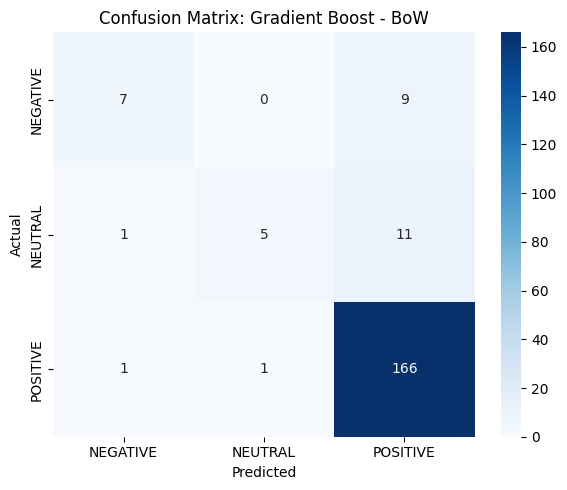

In [51]:
# Best model
best_model_label, best_f1, best_model, X_test_best, y_test_best, y_pred_best = results[0]

print(f"\n✅ Best Model: {best_model_label} (Macro F1 = {best_f1:.4f})\n")
print("Classification Report:\n")
print(classification_report(y_test_best, y_pred_best))

# Plot Confusion Matrix
cm = confusion_matrix(y_test_best, y_pred_best, labels=best_model.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title(f"Confusion Matrix: {best_model_label}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

<font size=6 color='blue'>Thanks.....</font>
___